# Library


In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import time
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# Setting

In [36]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define audio parameters
SAMPLE_RATE = 16000  # 16kHz sample rate
N_MFCC = 40          # Number of MFCC features
N_FFT = 400          # FFT window size
HOP_LENGTH = 160     # Hop length for STFT

# Path for audio data
TRAIN_AUDIO_PATH = 'Data_People/Training/'
TEST_AUDIO_PATH = 'Data_People/Testing/'

# Classes for classification
classes = ["SUBHANALLAH", "ALLAHUAKBAR", "ALHAMDULLILAH"]
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
idx_to_class = {idx: cls for idx, cls in enumerate(classes)}

Using device: cuda


# Dataset & Feature Extraction

In [37]:
# Audio Dataset Class
class AudioWordDataset(Dataset):
    def __init__(self, root_dir):
        """
        Args:
            root_dir (string): Directory with all the audio files.
        """
        self.root_dir = Path(root_dir)
        self.samples = []
        
        # Check if the root directory exists
        if not self.root_dir.exists():
            raise FileNotFoundError(f"Directory {root_dir} does not exist")
        
        # Walk through all files in directory
        for word_dir in self.root_dir.iterdir():
            if word_dir.is_dir() and word_dir.name in classes:
                word_class = word_dir.name
                for audio_file in word_dir.glob('*.wav'):
                    self.samples.append((str(audio_file), class_to_idx[word_class]))
        
        if len(self.samples) == 0:
            print(f"Warning: No audio files found in {root_dir}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        try:
            audio_path, label = self.samples[idx]
            
            # Load audio with error handling
            try:
                waveform, sample_rate = torchaudio.load(audio_path)
            except Exception as e:
                print(f"Error loading audio file {audio_path}: {e}")
                # Return a dummy waveform and the label
                return torch.zeros(1, 16000), label
            
            # Convert to mono if stereo
            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)
            
            # Ensure minimum length
            if waveform.shape[1] < 1000:  # Arbitrary minimum length
                waveform = torch.nn.functional.pad(waveform, (0, 1000 - waveform.shape[1]))
            
            # Limit maximum length to avoid memory issues
            max_length = 16000 * 5  # ~5 seconds at 16kHz
            if waveform.shape[1] > max_length:
                waveform = waveform[:, :max_length]
            
            # Extract MFCC features directly here to simplify the pipeline
            mfcc_transform = torchaudio.transforms.MFCC(
                sample_rate=sample_rate,
                n_mfcc=N_MFCC,
                melkwargs={
                    'n_fft': N_FFT,
                    'n_mels': 128,
                    'hop_length': HOP_LENGTH,
                }
            )
            
            # Extract features and normalize
            mfcc = mfcc_transform(waveform)
            mean = mfcc.mean()
            std = mfcc.std()
            mfcc = (mfcc - mean) / (std + 1e-10)
            
            return mfcc, label
        
        except Exception as e:
            print(f"Error processing sample {idx}: {e}")
            # Return a dummy tensor and the label
            return torch.zeros(N_MFCC, 100), 0

# CNN

In [38]:
# Define CNN Model
class AudioCNN(nn.Module):
    def __init__(self, n_mfcc=N_MFCC, n_classes=len(classes)):
        super(AudioCNN, self).__init__()
        
        # CNN layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.relu3 = nn.ReLU()
        
        # Adaptive pooling to handle variable size inputs
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        
        # FC layers with fixed input size due to adaptive pooling
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc_relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, n_classes)
    
    def forward(self, x):
        # Add channel dimension if necessary
        if x.dim() == 3:  # [batch, mfcc, time]
            x = x.unsqueeze(1)  # [batch, 1, mfcc, time]
        
        # CNN
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        
        # Adaptive pooling to handle variable sizes
        x = self.adaptive_pool(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # FC
        x = self.fc_relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [39]:
# Simplified collate function for variable length audio
def collate_fn(batch):
    # Filter out any None values that might have been returned from __getitem__
    batch = [(mfcc, label) for mfcc, label in batch if mfcc is not None]
    
    if len(batch) == 0:
        return torch.zeros(0, 1, N_MFCC, 100).to(device), torch.zeros(0).long().to(device)
    
    # Separate features and labels
    features, labels = zip(*batch)
    
    # Max length in the time dimension
    max_length = max([feature.shape[2] for feature in features])
    
    # Pad sequences to max length
    padded_features = []
    for feature in features:
        padding_size = max_length - feature.shape[2]
        if padding_size > 0:
            padded_feature = torch.nn.functional.pad(feature, (0, padding_size))
        else:
            padded_feature = feature
        padded_features.append(padded_feature)
    
    # Stack tensors
    features_tensor = torch.stack(padded_features)
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    
    return features_tensor, labels_tensor


# Data Loader


In [40]:
# Create data loaders with safer settings
def create_dataloaders(batch_size=16):
    try:
        # Create datasets with error handling
        train_dataset = AudioWordDataset(TRAIN_AUDIO_PATH)
        test_dataset = AudioWordDataset(TEST_AUDIO_PATH)
        
        print(f"Training samples: {len(train_dataset)}")
        print(f"Testing samples: {len(test_dataset)}")
        
        if len(train_dataset) == 0 or len(test_dataset) == 0:
            raise ValueError("One or both datasets are empty")
        
        # Create data loaders with fewer workers and persistent workers=False for stability
        train_loader = DataLoader(
            train_dataset, 
            batch_size=batch_size, 
            shuffle=True,
            collate_fn=collate_fn,
            num_workers=0,  # Use 0 for debugging, increase if stable
            pin_memory=True if torch.cuda.is_available() else False
        )
        
        test_loader = DataLoader(
            test_dataset, 
            batch_size=batch_size, 
            shuffle=False,
            collate_fn=collate_fn,
            num_workers=0,  # Use 0 for debugging, increase if stable
            pin_memory=True if torch.cuda.is_available() else False
        )
        
        return train_loader, test_loader
    
    except Exception as e:
        print(f"Error creating data loaders: {e}")
        raise


# Train & Validate

In [41]:
# Train in one epoch function
def train_one_epoch(model, train_loader, loss_fn, optimizer, device):
    model.train()
    train_loss, train_correct = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predictions = torch.max(outputs, 1)
        train_correct += torch.sum(predictions == labels.data)

    return train_loss / len(train_loader.dataset), train_correct.double() / len(train_loader.dataset)

def validate(model, val_loader, loss_fn, device, return_preds=False):
    model.eval()
    val_loss, val_correct = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predictions = torch.max(outputs, 1)
            val_correct += torch.sum(predictions == labels.data)

            if return_preds:
                all_preds.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

    if return_preds:
        return (
            val_loss / len(val_loader.dataset),
            val_correct.double() / len(val_loader.dataset),
            all_preds,
            all_labels,
        )
    else:
        return val_loss / len(val_loader.dataset), val_correct.double() / len(val_loader.dataset)

# Training and validation loop with timing
def train_and_validate(model, train_loader, val_loader, loss_fn, optimizer, epochs, device='cuda'):
    model.to(device)
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }

    for epoch in tqdm(range(epochs), desc="Training Progress", leave=True):
        epoch_start_time = time.time()

        train_loss, train_accuracy = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
        val_loss, val_accuracy = validate(model, val_loader, loss_fn, device)

        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_accuracy.item())
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy.item())

        epoch_end_time = time.time()

        tqdm.write(f'Epoch {epoch+1}/{epochs}: Train loss: {train_loss:.4f}, Train accuracy: {train_accuracy:.4f}, '
                   f'Val loss: {val_loss:.4f}, Val accuracy: {val_accuracy:.4f}, '
                   f'Time: {(epoch_end_time - epoch_start_time):.2f}s')

    return model, history


# Analysis

In [42]:
# Plot metrics
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    try:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(train_losses, label='Training Loss')
        ax1.plot(val_losses, label='Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.legend()
        
        # Plot accuracies
        ax2.plot(train_accs, label='Training Accuracy')
        ax2.plot(val_accs, label='Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.set_title('Training and Validation Accuracy')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting metrics: {e}")


In [43]:
# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    try:
        if len(y_true) == 0 or len(y_pred) == 0:
            print("No data to create confusion matrix")
            return
        
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=classes,
            yticklabels=classes
        )
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.show()
        
        # Calculate class-wise accuracy
        class_acc = cm.diagonal() / cm.sum(axis=1) * 100
        for i, acc in enumerate(class_acc):
            print(f'Accuracy for class {idx_to_class[i]}: {acc:.2f}%')
        
    except Exception as e:
        print(f"Error plotting confusion matrix: {e}")


# Main

In [44]:
# Hyperparameters
batch_size = 8  
learning_rate = 0.003
num_epochs = 50

In [45]:
# Create data loaders with error handling
train_loader, test_loader = create_dataloaders(batch_size)

Training samples: 57
Testing samples: 15


In [46]:
# Sample a batch to verify data shape before proceeding
for inputs, labels in train_loader:
    print(f"Sample batch shape: {inputs.shape}, Labels: {labels.shape}")
    break

Sample batch shape: torch.Size([8, 1, 40, 360]), Labels: torch.Size([8])


In [47]:

model = AudioCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [48]:
model, history = train_and_validate(model, train_loader, test_loader, criterion, optimizer, num_epochs, device)


Training Progress:   2%|▏         | 1/50 [00:00<00:38,  1.27it/s]

Epoch 1/50: Train loss: 2.4382, Train accuracy: 0.4035, Val loss: 1.3110, Val accuracy: 0.2667, Time: 0.78s


Training Progress:   4%|▍         | 2/50 [00:01<00:30,  1.58it/s]

Epoch 2/50: Train loss: 1.5411, Train accuracy: 0.4561, Val loss: 1.9729, Val accuracy: 0.3333, Time: 0.52s


Training Progress:   6%|▌         | 3/50 [00:01<00:29,  1.60it/s]

Epoch 3/50: Train loss: 1.5500, Train accuracy: 0.3684, Val loss: 1.3514, Val accuracy: 0.3333, Time: 0.61s


Training Progress:   8%|▊         | 4/50 [00:02<00:27,  1.69it/s]

Epoch 4/50: Train loss: 1.5267, Train accuracy: 0.4211, Val loss: 1.1151, Val accuracy: 0.3333, Time: 0.53s


Training Progress:  10%|█         | 5/50 [00:03<00:25,  1.75it/s]

Epoch 5/50: Train loss: 1.1998, Train accuracy: 0.2982, Val loss: 1.1538, Val accuracy: 0.3333, Time: 0.53s


Training Progress:  12%|█▏        | 6/50 [00:03<00:24,  1.76it/s]

Epoch 6/50: Train loss: 1.1588, Train accuracy: 0.4035, Val loss: 1.1111, Val accuracy: 0.4000, Time: 0.55s


Training Progress:  14%|█▍        | 7/50 [00:04<00:23,  1.83it/s]

Epoch 7/50: Train loss: 1.2752, Train accuracy: 0.2982, Val loss: 1.2485, Val accuracy: 0.3333, Time: 0.50s


Training Progress:  16%|█▌        | 8/50 [00:04<00:23,  1.80it/s]

Epoch 8/50: Train loss: 1.1617, Train accuracy: 0.3158, Val loss: 1.1369, Val accuracy: 0.3333, Time: 0.57s


Training Progress:  18%|█▊        | 9/50 [00:05<00:22,  1.85it/s]

Epoch 9/50: Train loss: 1.1274, Train accuracy: 0.2982, Val loss: 1.1032, Val accuracy: 0.4000, Time: 0.50s


Training Progress:  20%|██        | 10/50 [00:05<00:21,  1.89it/s]

Epoch 10/50: Train loss: 1.1105, Train accuracy: 0.3509, Val loss: 1.0932, Val accuracy: 0.2667, Time: 0.50s


Training Progress:  22%|██▏       | 11/50 [00:06<00:21,  1.85it/s]

Epoch 11/50: Train loss: 1.0752, Train accuracy: 0.4737, Val loss: 1.0960, Val accuracy: 0.3333, Time: 0.56s


Training Progress:  24%|██▍       | 12/50 [00:06<00:20,  1.85it/s]

Epoch 12/50: Train loss: 1.0991, Train accuracy: 0.3509, Val loss: 1.1154, Val accuracy: 0.3333, Time: 0.53s


Training Progress:  26%|██▌       | 13/50 [00:07<00:20,  1.80it/s]

Epoch 13/50: Train loss: 1.1266, Train accuracy: 0.3684, Val loss: 1.1536, Val accuracy: 0.3333, Time: 0.58s


Training Progress:  28%|██▊       | 14/50 [00:07<00:19,  1.84it/s]

Epoch 14/50: Train loss: 1.1276, Train accuracy: 0.3509, Val loss: 1.1018, Val accuracy: 0.3333, Time: 0.51s


Training Progress:  30%|███       | 15/50 [00:08<00:18,  1.88it/s]

Epoch 15/50: Train loss: 1.1155, Train accuracy: 0.3158, Val loss: 1.1046, Val accuracy: 0.3333, Time: 0.50s


Training Progress:  32%|███▏      | 16/50 [00:08<00:18,  1.83it/s]

Epoch 16/50: Train loss: 1.0804, Train accuracy: 0.4386, Val loss: 1.1069, Val accuracy: 0.3333, Time: 0.58s


Training Progress:  34%|███▍      | 17/50 [00:09<00:18,  1.79it/s]

Epoch 17/50: Train loss: 1.0918, Train accuracy: 0.3333, Val loss: 1.1099, Val accuracy: 0.3333, Time: 0.57s


Training Progress:  36%|███▌      | 18/50 [00:10<00:19,  1.64it/s]

Epoch 18/50: Train loss: 1.0862, Train accuracy: 0.4035, Val loss: 1.0932, Val accuracy: 0.3333, Time: 0.73s


Training Progress:  38%|███▊      | 19/50 [00:10<00:18,  1.67it/s]

Epoch 19/50: Train loss: 1.0714, Train accuracy: 0.3860, Val loss: 1.0952, Val accuracy: 0.2667, Time: 0.56s


Training Progress:  40%|████      | 20/50 [00:11<00:18,  1.65it/s]

Epoch 20/50: Train loss: 1.1026, Train accuracy: 0.3333, Val loss: 1.0946, Val accuracy: 0.2667, Time: 0.62s


Training Progress:  42%|████▏     | 21/50 [00:11<00:16,  1.71it/s]

Epoch 21/50: Train loss: 1.0934, Train accuracy: 0.3333, Val loss: 1.1036, Val accuracy: 0.4000, Time: 0.54s


Training Progress:  44%|████▍     | 22/50 [00:12<00:16,  1.72it/s]

Epoch 22/50: Train loss: 1.0996, Train accuracy: 0.3509, Val loss: 1.0903, Val accuracy: 0.4000, Time: 0.57s


Training Progress:  46%|████▌     | 23/50 [00:13<00:15,  1.80it/s]

Epoch 23/50: Train loss: 1.0954, Train accuracy: 0.3333, Val loss: 1.0864, Val accuracy: 0.3333, Time: 0.49s


Training Progress:  48%|████▊     | 24/50 [00:13<00:14,  1.83it/s]

Epoch 24/50: Train loss: 1.0759, Train accuracy: 0.3860, Val loss: 1.0824, Val accuracy: 0.3333, Time: 0.52s


Training Progress:  50%|█████     | 25/50 [00:14<00:13,  1.79it/s]

Epoch 25/50: Train loss: 1.0742, Train accuracy: 0.3684, Val loss: 1.0717, Val accuracy: 0.4000, Time: 0.58s


Training Progress:  52%|█████▏    | 26/50 [00:14<00:13,  1.81it/s]

Epoch 26/50: Train loss: 1.0040, Train accuracy: 0.4561, Val loss: 1.1049, Val accuracy: 0.4000, Time: 0.53s


Training Progress:  54%|█████▍    | 27/50 [00:15<00:12,  1.80it/s]

Epoch 27/50: Train loss: 0.9857, Train accuracy: 0.5439, Val loss: 1.0778, Val accuracy: 0.3333, Time: 0.56s


Training Progress:  56%|█████▌    | 28/50 [00:15<00:12,  1.82it/s]

Epoch 28/50: Train loss: 1.0054, Train accuracy: 0.4211, Val loss: 1.0568, Val accuracy: 0.4667, Time: 0.53s


Training Progress:  58%|█████▊    | 29/50 [00:16<00:11,  1.87it/s]

Epoch 29/50: Train loss: 1.0987, Train accuracy: 0.5614, Val loss: 0.9896, Val accuracy: 0.4667, Time: 0.50s


Training Progress:  60%|██████    | 30/50 [00:16<00:11,  1.81it/s]

Epoch 30/50: Train loss: 1.1041, Train accuracy: 0.3333, Val loss: 1.4549, Val accuracy: 0.3333, Time: 0.59s


Training Progress:  62%|██████▏   | 31/50 [00:17<00:10,  1.86it/s]

Epoch 31/50: Train loss: 1.0662, Train accuracy: 0.4737, Val loss: 1.2227, Val accuracy: 0.4667, Time: 0.50s


Training Progress:  64%|██████▍   | 32/50 [00:17<00:09,  1.82it/s]

Epoch 32/50: Train loss: 0.9437, Train accuracy: 0.5789, Val loss: 1.0618, Val accuracy: 0.4667, Time: 0.57s


Training Progress:  66%|██████▌   | 33/50 [00:18<00:09,  1.86it/s]

Epoch 33/50: Train loss: 1.0677, Train accuracy: 0.4211, Val loss: 1.0365, Val accuracy: 0.4667, Time: 0.51s


Training Progress:  68%|██████▊   | 34/50 [00:19<00:08,  1.89it/s]

Epoch 34/50: Train loss: 0.9845, Train accuracy: 0.5263, Val loss: 1.0019, Val accuracy: 0.4000, Time: 0.51s


Training Progress:  70%|███████   | 35/50 [00:19<00:08,  1.86it/s]

Epoch 35/50: Train loss: 0.9582, Train accuracy: 0.5088, Val loss: 0.9336, Val accuracy: 0.5333, Time: 0.55s


Training Progress:  72%|███████▏  | 36/50 [00:20<00:07,  1.88it/s]

Epoch 36/50: Train loss: 0.9358, Train accuracy: 0.5088, Val loss: 0.9436, Val accuracy: 0.4667, Time: 0.51s


Training Progress:  74%|███████▍  | 37/50 [00:20<00:07,  1.83it/s]

Epoch 37/50: Train loss: 0.8372, Train accuracy: 0.6842, Val loss: 0.9037, Val accuracy: 0.6000, Time: 0.57s


Training Progress:  76%|███████▌  | 38/50 [00:21<00:06,  1.86it/s]

Epoch 38/50: Train loss: 0.9325, Train accuracy: 0.4386, Val loss: 0.9004, Val accuracy: 0.6667, Time: 0.51s


Training Progress:  78%|███████▊  | 39/50 [00:21<00:05,  1.85it/s]

Epoch 39/50: Train loss: 0.9088, Train accuracy: 0.5789, Val loss: 0.8898, Val accuracy: 0.5333, Time: 0.54s


Training Progress:  80%|████████  | 40/50 [00:22<00:05,  1.80it/s]

Epoch 40/50: Train loss: 0.8896, Train accuracy: 0.4561, Val loss: 0.7735, Val accuracy: 0.7333, Time: 0.59s


Training Progress:  82%|████████▏ | 41/50 [00:22<00:04,  1.84it/s]

Epoch 41/50: Train loss: 0.7555, Train accuracy: 0.6316, Val loss: 0.7933, Val accuracy: 0.6667, Time: 0.51s


Training Progress:  84%|████████▍ | 42/50 [00:23<00:04,  1.81it/s]

Epoch 42/50: Train loss: 0.7527, Train accuracy: 0.6140, Val loss: 0.7102, Val accuracy: 0.7333, Time: 0.57s


Training Progress:  86%|████████▌ | 43/50 [00:23<00:03,  1.84it/s]

Epoch 43/50: Train loss: 0.8322, Train accuracy: 0.6316, Val loss: 0.8090, Val accuracy: 0.6000, Time: 0.52s


Training Progress:  88%|████████▊ | 44/50 [00:24<00:03,  1.82it/s]

Epoch 44/50: Train loss: 0.8167, Train accuracy: 0.5789, Val loss: 0.6979, Val accuracy: 0.8000, Time: 0.56s


Training Progress:  90%|█████████ | 45/50 [00:25<00:02,  1.86it/s]

Epoch 45/50: Train loss: 0.7797, Train accuracy: 0.6140, Val loss: 0.6860, Val accuracy: 0.6667, Time: 0.50s


Training Progress:  92%|█████████▏| 46/50 [00:25<00:02,  1.84it/s]

Epoch 46/50: Train loss: 0.6679, Train accuracy: 0.6316, Val loss: 0.7339, Val accuracy: 0.6667, Time: 0.55s


Training Progress:  94%|█████████▍| 47/50 [00:26<00:01,  1.87it/s]

Epoch 47/50: Train loss: 0.6858, Train accuracy: 0.6842, Val loss: 0.6554, Val accuracy: 0.6667, Time: 0.51s


Training Progress:  96%|█████████▌| 48/50 [00:26<00:01,  1.82it/s]

Epoch 48/50: Train loss: 0.8465, Train accuracy: 0.5965, Val loss: 0.8428, Val accuracy: 0.5333, Time: 0.58s


Training Progress:  98%|█████████▊| 49/50 [00:27<00:00,  1.83it/s]

Epoch 49/50: Train loss: 0.9788, Train accuracy: 0.4386, Val loss: 0.7974, Val accuracy: 0.5333, Time: 0.54s


Training Progress: 100%|██████████| 50/50 [00:27<00:00,  1.80it/s]

Epoch 50/50: Train loss: 0.7860, Train accuracy: 0.6140, Val loss: 0.7546, Val accuracy: 0.6667, Time: 0.57s


Accuracy of the model is: 0.6666666666666666


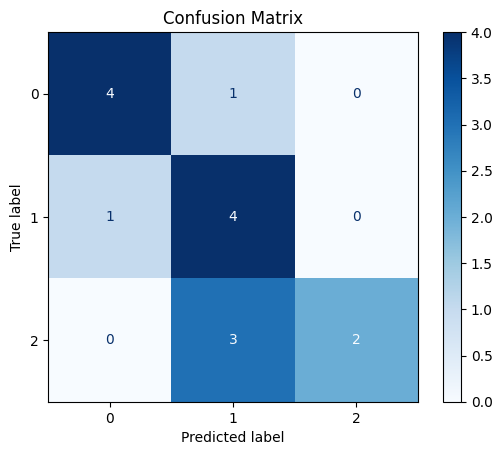

In [50]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Switch to evaluation mode
model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().tolist())
        y_pred.extend(predicted.cpu().tolist())

# Accuracy
print('Accuracy of the model is:', accuracy_score(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


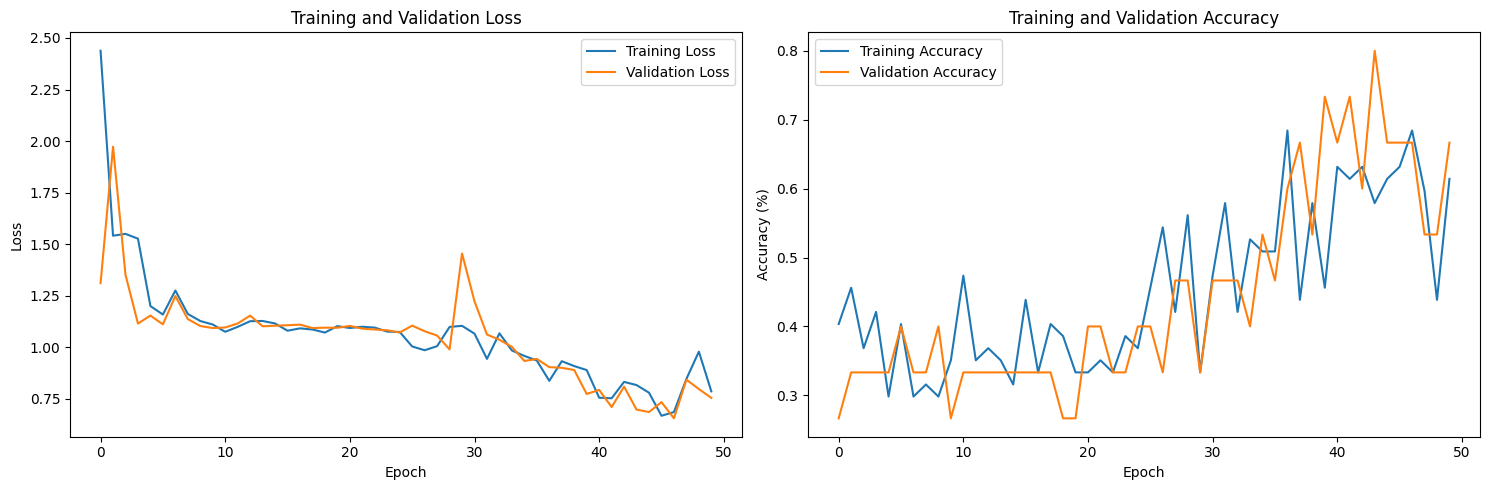

Confusion Matrix:


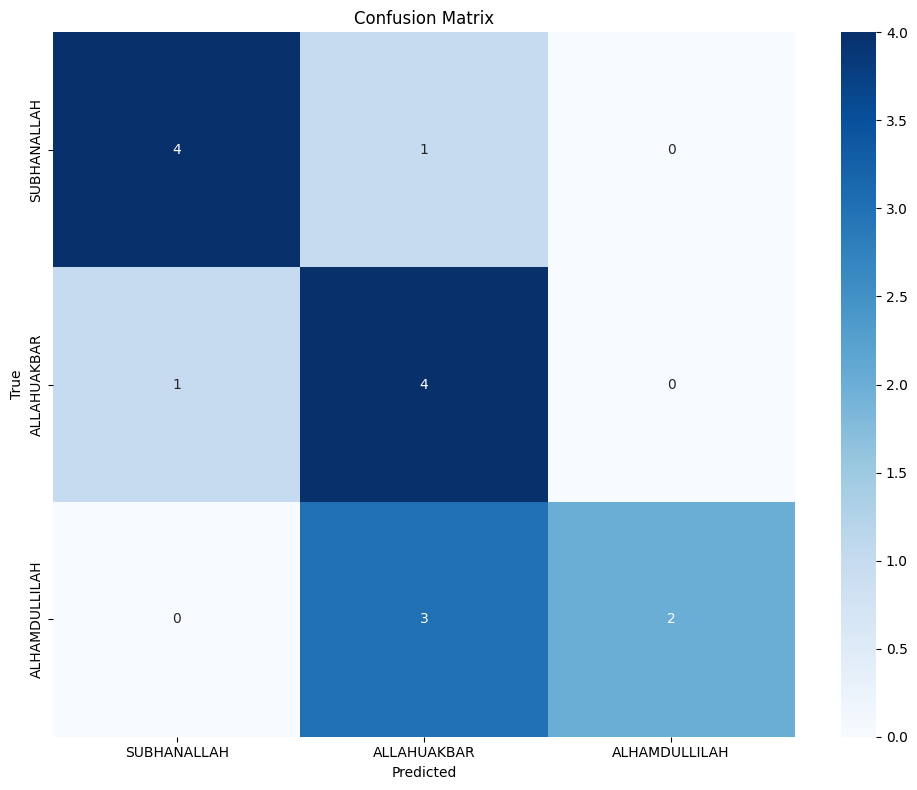

Accuracy for class SUBHANALLAH: 80.00%
Accuracy for class ALLAHUAKBAR: 80.00%
Accuracy for class ALHAMDULLILAH: 40.00%


In [51]:
# Plot metrics
plot_metrics(history['train_loss'], history['val_loss'], history['train_accuracy'], history['val_accuracy'])

# Final evaluation (with predictions for confusion matrix)
_, _, all_preds, all_labels = validate(model, test_loader, criterion, device, return_preds=True) # type: ignore
print("Confusion Matrix:")
plot_confusion_matrix(all_labels, all_preds)
